## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)



---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp

In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
!pip install datasets


In [ ]:
from datasets import load_dataset
dataset = load_dataset('emotion')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [ ]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [ ]:
tweets,labels=get_tweet(train)

In [ ]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [ ]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

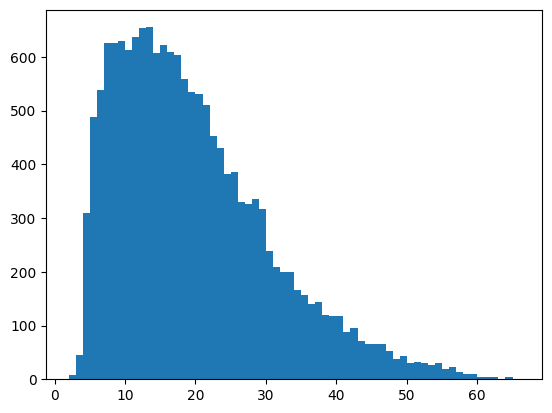

In [ ]:
lengths=[len(t.split(' '))for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [ ]:
maxlen=50
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [ ]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [ ]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


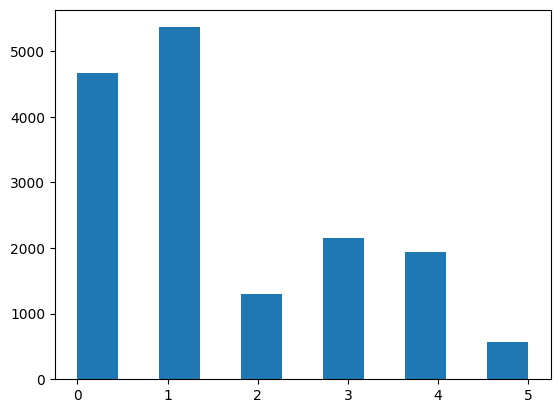

In [ ]:
plt.hist(labels , bins=11)
plt.show()

In [ ]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [ ]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [ ]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.build(input_shape=(None, maxlen))

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:

val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [ ]:
print(val_tweets[0], val_labels[0])

im feeling quite sad and sorry for myself but ill snap out of it soon 0


In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.3524 - loss: 1.5765 - val_accuracy: 0.6435 - val_loss: 0.9901
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.7435 - loss: 0.7419 - val_accuracy: 0.8360 - val_loss: 0.4766
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8882 - loss: 0.3383 - val_accuracy: 0.8725 - val_loss: 0.3908
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9418 - loss: 0.1868 - val_accuracy: 0.8840 - val_loss: 0.3718
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9620 - loss: 0.1265 - val_accuracy: 0.8730 - val_loss: 0.4424
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9717 - loss: 0.0958 - val_accuracy: 0.8860 - val_loss: 0.4132
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9780 - loss: 0.0733 - val_accuracy: 0.8820 - val_loss: 0.4314
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9806 - loss: 0.0658 - va

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

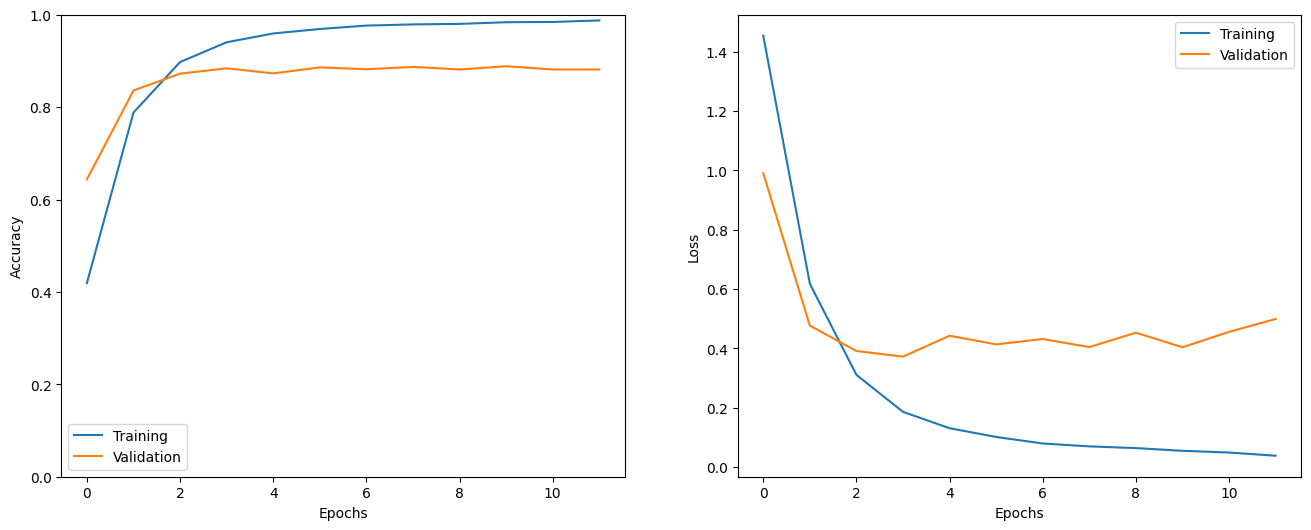

In [ ]:
show_history(h)

In [ ]:

test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8786 - loss: 0.4889


In [ ]:
i=0
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])
i=0
print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: im feeling rather rotten so im not very ambitious right now
Emotion: 0
Sentence: im feeling rather rotten so im not very ambitious right now
Emotion: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
Predicted Emotion: 0


In [ ]:
preds = model.predict(test_seq)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


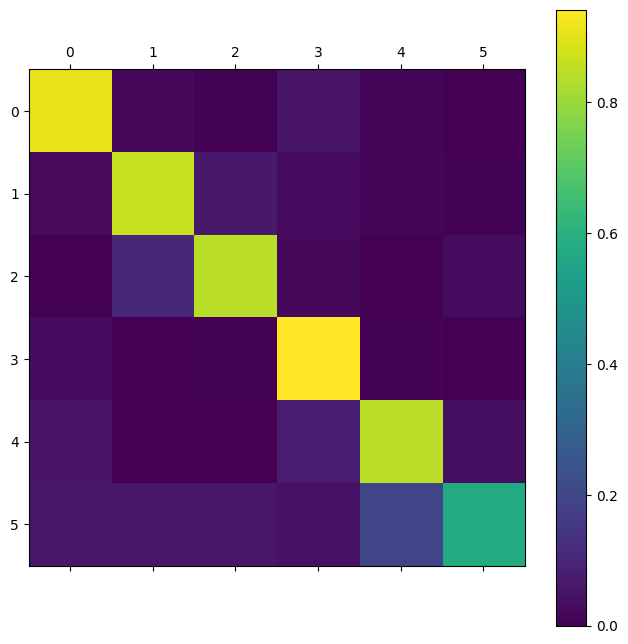

In [ ]:
preds = np.argmax(model.predict(test_seq), axis=-1)
show_confusion_matrix(test_labels, preds, list(classes))